In [34]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings("ignore")


In [35]:
# --------------------------
# SELECT MODEL
# --------------------------
model_choice = 'lgbm'  # 'rf', 'gb', 'cb', 'lgbm'

# --------------------------
# INSERT BEST PARAMETERS
# --------------------------
best_params = {
    # Replace with your best parameters
    'n_estimators'      : 400,
    'learning_rate'     : 0.01,
    'max_depth'         : -1,
    'num_leaves'        : 127,
    'min_child_samples' : 20,
    'subsample'         : 1.0,
    'colsample_bytree'  : 1.0,
    'reg_alpha'         : 2,
    'reg_lambda'        : 3
}


In [36]:
path = "C:/Users/Dell/Downloads/training/"

X_train = pd.read_csv(path + 'X_train_20260212.csv')
y_train = pd.read_csv(path + 'y_train_20260212.csv').iloc[:, 0]

X_eval = pd.read_csv(path + 'X_eval_20260212.csv')
y_eval = pd.read_csv(path + 'y_eval_20260212.csv').iloc[:, 0]


In [37]:
# Initialise model
models = {
    'rf': RandomForestRegressor(random_state=42, n_jobs=-1),
    'gb': GradientBoostingRegressor(random_state=42),
    'cb': CatBoostRegressor(random_state=42, silent=True),
    'lgbm': lgb.LGBMRegressor(random_state=42, n_jobs=-1)
}

if model_choice == 'cb':
    model = CatBoostRegressor(random_state=42, silent=True, **best_params)
else:
    model = models[model_choice].set_params(**best_params)


In [38]:
# Evaluation
tscv = TimeSeriesSplit(n_splits=5)

cv_metrics = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train), 1):
    
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_val)
    
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    
    cv_metrics.append([fold, mae, rmse, r2])

cv_results = pd.DataFrame(
    cv_metrics,
    columns=["Fold", "MAE", "RMSE", "R2"]
)

cv_results


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1193
[LightGBM] [Info] Number of data points in the train set: 368, number of used features: 29
[LightGBM] [Info] Start training from score 39.546060
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

,Fold,MAE,RMSE,R2
0,1,2.946355,4.431520,0.287540
1,2,1.719272,2.494662,0.685929
2,3,1.043891,1.978712,0.830749
3,4,1.373019,2.156315,0.712074
4,5,1.055224,2.098240,0.764190


In [39]:
cv_summary = cv_results.describe().loc[['mean','std']]
cv_summary

,Fold,MAE,RMSE,R2
mean,3.000000,1.627552,2.631890,0.656096
std,1.581139,0.787506,1.024097,0.213334


In [40]:
# Train model on full training data
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3402
[LightGBM] [Info] Number of data points in the train set: 2208, number of used features: 29
[LightGBM] [Info] Start training from score 39.036851
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

,boosting_type,'gbdt'
,num_leaves,127
,max_depth,-1
,learning_rate,0.01
,n_estimators,400
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [41]:
# Training performance (In sample)
y_train_pred = model.predict(X_train)

train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

train_bias = np.mean(y_train_pred - y_train)
train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100


In [42]:
# Final model on evaluation set (True OOS)

y_eval_pred = model.predict(X_eval)

eval_mae = mean_absolute_error(y_eval, y_eval_pred)
eval_rmse = np.sqrt(mean_squared_error(y_eval, y_eval_pred))
eval_r2 = r2_score(y_eval, y_eval_pred)

eval_bias = np.mean(y_eval_pred - y_eval)
eval_mape = np.mean(np.abs((y_eval - y_eval_pred) / y_eval)) * 100


In [43]:
# Metrics summary table
final_results = pd.DataFrame({
    "Dataset": ["Training", "Evaluation"],
    "MAE": [train_mae, eval_mae],
    "RMSE": [train_rmse, eval_rmse],
    "R2": [train_r2, eval_r2],
    "MAPE (%)": [train_mape, eval_mape],
    "Bias": [train_bias, eval_bias]
})

final_results


,Dataset,MAE,RMSE,R2,MAPE (%),Bias
0,Training,0.634616,1.170011,0.948173,1.654912,0.001188
1,Evaluation,1.119773,2.000033,0.181023,3.379273,0.891272


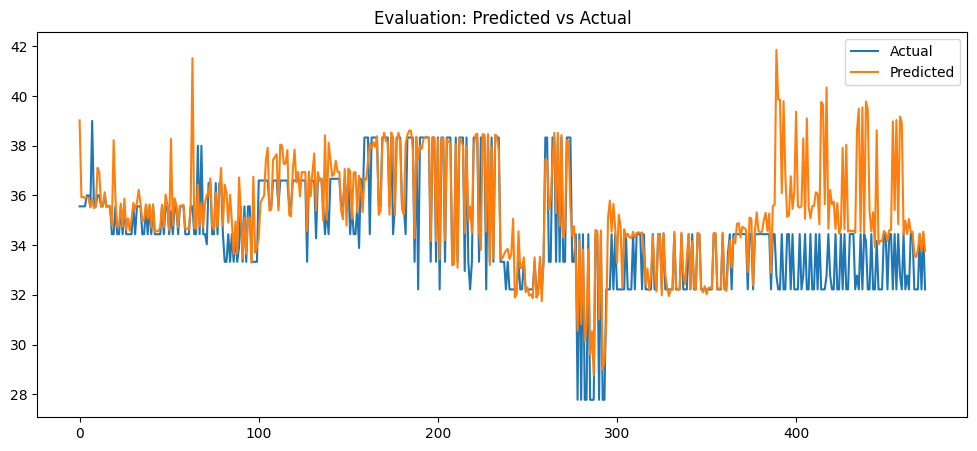

In [44]:
# Diagnotstic plots

plt.figure(figsize=(12,5))
plt.plot(y_eval.values, label="Actual")
plt.plot(y_eval_pred, label="Predicted")
plt.legend()
plt.title("Evaluation: Predicted vs Actual")
plt.show()

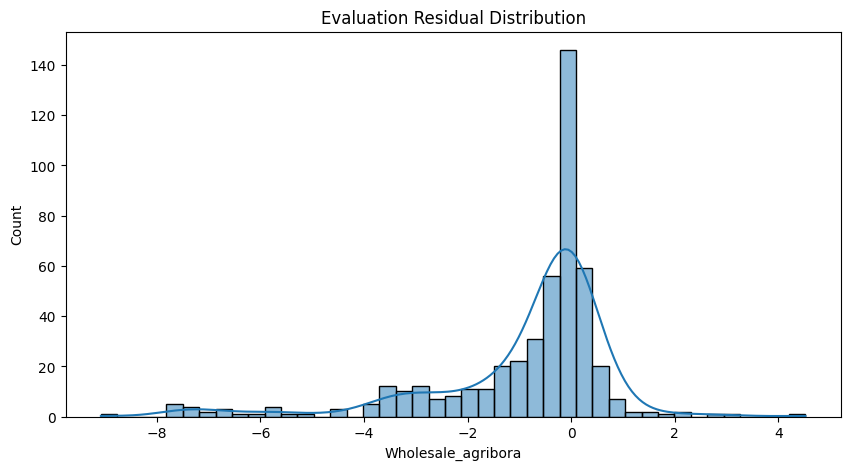

In [45]:
residuals = y_eval - y_eval_pred

plt.figure(figsize=(10,5))
sns.histplot(residuals, kde=True)
plt.title("Evaluation Residual Distribution")
plt.show()


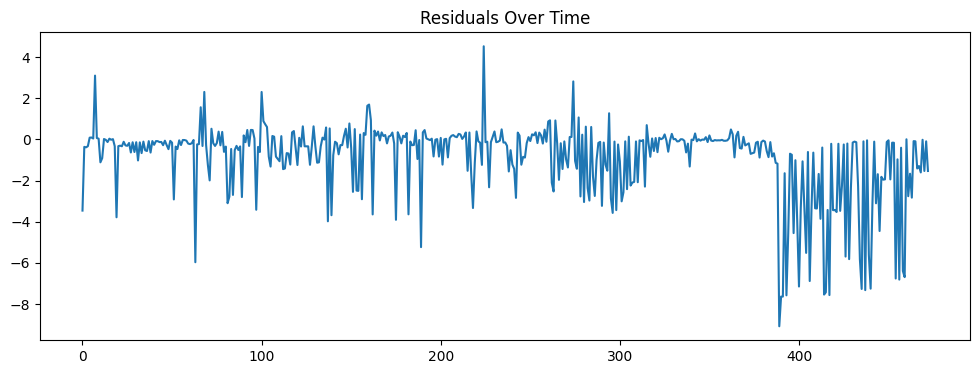

In [46]:
plt.figure(figsize=(12,4))
plt.plot(residuals)
plt.title("Residuals Over Time")
plt.show()


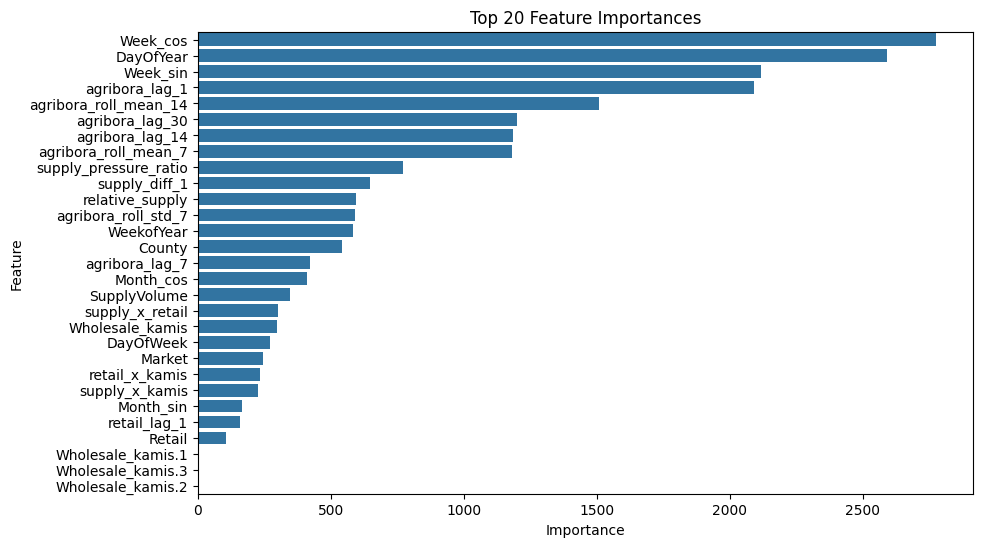

In [47]:
if hasattr(model, "feature_importances_"):
    fi = pd.DataFrame({
        "Feature": X_train.columns,
        "Importance": model.feature_importances_
    }).sort_values("Importance", ascending=False)
    
    plt.figure(figsize=(10,6))
    sns.barplot(x="Importance", y="Feature", data=fi.head(29))
    plt.title("Top 20 Feature Importances")
    plt.show()
    
    fi.head(29)


In [48]:
overfit_gap = eval_rmse - train_rmse
print("RMSE Generalization Gap:", overfit_gap)


RMSE Generalization Gap: 0.8300221386385604


In [49]:
print("===== FINAL MODEL SUMMARY =====")
print(final_results)
print("\nCV Mean RMSE:", cv_summary.loc['mean','RMSE'])
print("CV RMSE Std:", cv_summary.loc['std','RMSE'])


===== FINAL MODEL SUMMARY =====
      Dataset       MAE      RMSE        R2  MAPE (%)      Bias
0    Training  0.634616  1.170011  0.948173  1.654912  0.001188
1  Evaluation  1.119773  2.000033  0.181023  3.379273  0.891272

CV Mean RMSE: 2.631889641202526
CV RMSE Std: 1.0240965077805397
